# Plot onset channel sgrams with clinical onsets

In [16]:
import numpy as np
import pandas as pd
import os
import scipy.io
import ieeg_funcs as ief
import re
import dgFuncs as dg
from sklearn import preprocessing
import sys
from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Block for re-loading my libraries if I make updates
import imp 
imp.reload(ief) 
imp.reload(dg) 

<module 'dgFuncs' from '/Users/davidgroppe/PycharmProjects/DG_LIBRARY/dgFuncs.py'>

In [3]:
path_dict=ief.get_path_dict()
path_dict['ieeg_root']

'/Users/davidgroppe/ONGOING/TWH_EEG/'

In [5]:
# Check to make sure my trimmed_mn_sd code is working
# bro=np.arange(1,10)
bro=np.random.randn(10)
print(bro.shape)
from scipy import stats
trm_pptn=.1
[mn, sd]=dg.trimmed_mn_sd(bro,trm_pptn)
print('DG mn %f' % mn)
sp_mn=stats.trim_mean(bro, trm_pptn)
print('Scipy mn %f' % sp_mn)

(10,)
DG mn 0.321804
Scipy mn 0.321804


In [6]:
bro=np.random.randn(2,4)
print(bro)
broZ, _, _=dg.trimmed_normalize(bro,.25)
print(broZ)

[[ 1.38486159  1.48451296 -0.23260785 -0.72307459]
 [-0.69322558  1.20442608  0.22695313 -0.31237265]]
2 dimensions
4 observations
[[ 1.          1.12321886 -1.         -1.60646182]
 [-2.41232978  4.62479592  1.         -1.        ]]


In [7]:
# Define sub and onset channel
sub='TF'
#sub='NA'
onset_df=pd.read_csv('/Users/davidgroppe/PycharmProjects/SZR_ANT/chans_of_interest.csv',na_filter=False)
row_id=onset_df[onset_df.iloc[:,0]==sub].index.tolist()
onset_chan=onset_df.iloc[row_id[0],1].strip() #strip removes white space
print('Sub=%s, onset chan=%s' % (sub,onset_chan))

Sub=TF, onset chan=RHD1-2


In [8]:
# Load manual onset times
csv_path='/Users/davidgroppe/ONGOING/SZR_SPREAD/PATIENTS/'+sub+'/ONSETTIMES/'
print('Importing manual onset times from %s' % csv_path)
csv_list=list()
for f in os.listdir(csv_path):
    if f.endswith('manualOnsets.txt'):
        csv_list.append(f)

n_files=len(csv_list)
print('%d manual wide-band onset files found' % n_files)

Importing manual onset times from /Users/davidgroppe/ONGOING/SZR_SPREAD/PATIENTS/TF/ONSETTIMES/
14 manual wide-band onset files found


In [9]:
# Import Clinician Szr Onset Times
if sys.platform=='linux':
    onset_csv_dir='/home/dgroppe/TWH_INFO/CLINICIAN_ONSET_TIMES'
else:
    onset_csv_dir='/Users/davidgroppe/Dropbox/TWH_INFO/CLINICIAN_ONSET_TIMES'
onset_csv_fname=os.path.join(onset_csv_dir,sub+'_clinician_onset_offset.csv')
print('Importing file %s' % onset_csv_fname)
onset_df=pd.read_csv(onset_csv_fname)

Importing file /Users/davidgroppe/Dropbox/TWH_INFO/CLINICIAN_ONSET_TIMES/TF_clinician_onset_offset.csv


In [10]:
onset_df.head()

,DAY,SZR#,ONSET,OFFSET,SOZ_CHAN,FILE_ONSET,DDMMYR,SRATE_HZ,NOTES,ONSET_SEC,FILE_ONSET_SEC,ONSET_TPT,DG_ONSET_CHAN,USE4CLASSIFIER
0,1,1,4:15:01 PM,4:16:41 PM,?,16:14:24,09/01/2009,500,NaN,58501,58464,18500,?,noEEGdata
1,4,1,9:24:44 AM,9:25:28 AM,?,9:23:37,09/04/2009,500,anterior temporal neocortex and hippo,33884,33817,33500,?,noEEGdata
2,4,2,11:50:07 PM,11:50:46 PM,?,23:47:54,09/04/2009,500,NaN,85807,85674,66500,RHD1-2,use
3,4,3,12:57:08 AM,12:57:52 AM,?,0:54:22,09/05/2009,500,anterior neocortical and hippocamapal regions,3428,3262,83000,RHD1-2,use
4,5,1,3:17:15 PM,3:21:54 PM,?,15:14:00,09/05/2009,500,NaN,55035,54840,97500,RHD1-2,use


In [11]:
# def clin_onset_tpt(szr_name, onset_df):
#     import re
#     name_splt=szr_name.split('_')
#     day=int(name_splt[1][1:])
#     szr=int(re.findall('[0-9]+',name_splt[2])[0])
#     print('Getting clinical onset time for %s: Day %d, Szr %d' % (name_splt[0],day,szr))

#     # temp_df=onset_df[onset_df['DAY']==day and onset_df['SZR#']==2]
#     day_ids=onset_df[onset_df['DAY']==day].index 
#     szr_ids=onset_df[onset_df['SZR#']==szr].index 
#     use_id=day_ids.intersection(szr_ids)
#     if len(use_id)==0:
#         onset_tpt=NaN
#     else:
#         onset_tpt=onset_df['ONSET_TPT'].iloc[use_id].values[0]
#     return onset_tpt

# onset_tpt=clin_onset_tpt('NA_d1_sz2.mat',onset_df)

In [12]:
# def get_ieeg_root_dir():
#     if sys.platform=='linux':
#         ieeg_root='/home/dgroppe/TWH_EEG'
#     else:
#         ieeg_root='/Users/davidgroppe/ONGOING/SZR_SPREAD/PATIENTS/'
#     return ieeg_root
        
# def import_ieeg(ieeg_mat_fname):
#     """ Import iEEG data from mat file and remove mean of each channel
#     For example:
#     ieeg, Sf, tpts_sec=import_ieeg('NA_d1_sz2.mat')"""
#     ieeg_root=get_ieeg_root_dir()
#     ieeg_dir=os.path.join(ieeg_root,sub,'Data')
#     ieeg_fname=os.path.join(ieeg_dir,ieeg_mat_fname)
#     print('Loading %s' % ieeg_fname)
#     mat=scipy.io.loadmat(ieeg_fname)
#     Sf=mat['Sf'][0][0]
#     ieeg=mat['matrix_bi']
#     ieeg=ieeg.T
#     n_chan, n_tpt=ieeg.shape
#     # remove mean of each channel
#     for chan_loop in range(n_chan):
#         ieeg[chan_loop,:]=ieeg[chan_loop,:]-np.mean(ieeg[chan_loop,:])
#     tpts_sec=np.arange(0,n_tpt)/Sf
#     tpts_sec=tpts_sec.T
#     return ieeg, Sf, tpts_sec

# def import_chan_labels(sub):
#     """ Import channel labels as list of strings. For example:
#     chan_labels=import_chan_labels('NA')"""
#     ieeg_root=get_ieeg_root_dir()
#     chan_fname=os.path.join(ieeg_root,sub,
#                         sub+'_channel_info.csv')
#     print('Loading %s' % chan_fname)
#     chan_labels_df=pd.read_csv(chan_fname,names=['label'])
#     # Convert to list and remove redundant electrode stem for second electrode in each bipolar pair
#     chan_labels=ief.clean_labels(list(chan_labels_df['label']))
#     return chan_labels

In [13]:
# Get list of channels and ID of onset channel
chan_labels=ief.import_chan_labels(sub)
onset_chan_id=chan_labels.index(onset_chan)

Loading /Users/davidgroppe/ONGOING/TWH_EEG/TF/TF_channel_info.csv


TF_d4_sz2
Getting clinical onset time for TF: Day 4, Szr 2
Loading /Users/davidgroppe/ONGOING/TWH_EEG/TF/EEG_MAT/TF_d4_sz2.mat
201 dimensions
1710 observations
9648 dimensions
1710 observations


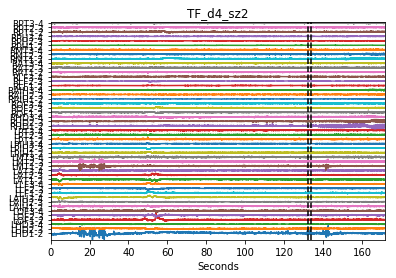

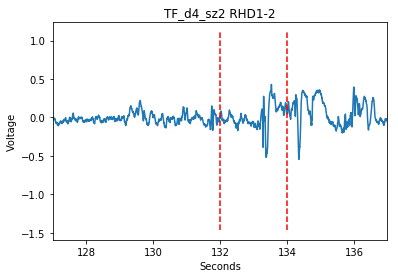

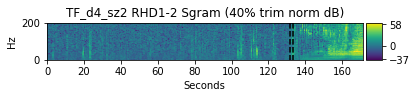

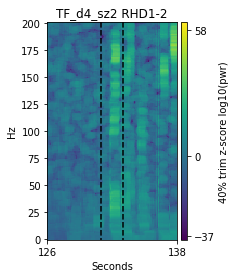

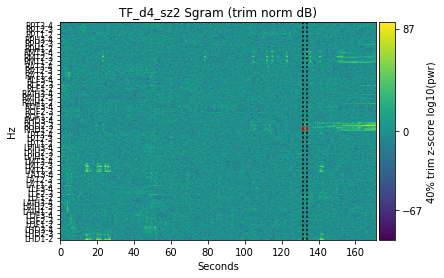

In [15]:
imp.reload(ief) 
n_chan=len(chan_labels)

# Loop through manual files (since I have one for each mat file)
#for man_file_loop in range(n_files): TODO use this!!!
for man_file_loop in range(1):
    szr_name=csv_list[man_file_loop].split('_manualOnsets')[0]
    #     digit_substrings=re.findall(r'\d+',csv_list[man_file_loop])
    #     szr_day=int(digit_substrings[0])
    #     szr_num=int(digit_substrings[1])

    # See if I have a clinician onset
    print(szr_name)
    # ?? onset_tpt=ief.clin_onset_tpt(szr_name, onset_df)
    onset_tpt, onset_chan=ief.clin_onset_tpt_and_chan(szr_name, onset_df)
    
    if onset_tpt<0:
        print('Warning: %s has a clinician onset time that is earlier than the file start time.' % szr_name)
        print('Ignoring this szr for the time being')
        onset_tpt=np.nan
    elif np.isnan(onset_tpt):
        print('Warning: %s has no clinician onset time.'  % szr_name)
        print('Ignoring this szr for the time being')
    else:
        # Load the ieeg data
        ieeg, Sf, tpts_sec=ief.import_ieeg(szr_name+'.mat')
        
        # Calcuate onset window (there is uncertainty due second resolution of Xltek text files)
        onset_upper_bnd_sec=(onset_tpt/Sf)+1
        onset_lower_bnd_sec=(onset_tpt/Sf)-1
    
        # Plot voltage time series at all channels and onset
        [h, ax]=ief.strat_plot(ieeg,chan_labels,tpts_sec=tpts_sec)
        ylim=ax.get_ylim()
        plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
        plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')
        plt.title(szr_name)
    
        # Plot voltage time series at just the onset channel
        plt.figure(2)
        plt.clf()
        plt.plot(tpts_sec,ieeg[onset_chan_id,:])
        plt.xlim([onset_lower_bnd_sec-5, onset_upper_bnd_sec+3])
        ax=plt.gca()
        ylim=ax.get_ylim()
        plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'r--')
        plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'r--')
        plt.xlabel('Seconds')
        plt.ylabel('Voltage')
        plt.title(szr_name+' '+chan_labels[onset_chan_id])
    
        # Compute spectrogram at onset channel
        wind_len=Sf
        wind_step=Sf/10
        n_tapers=4
        sgram, f, sgram_sec=ief.mt_sgram(ieeg[onset_chan_id,:],Sf,wind_len,wind_step,n_tapers,tpts_sec)
        cutoff_freq=Sf*.4 # remove frequencies above anti-aliasing filter cutoff
        f=f[f<=cutoff_freq]
        n_freq=len(f)
        sgram=sgram[:n_freq,:]
        n_wind=len(sgram_sec)
    
        # Plot sgram at just onset channel with onset overlay
        plt.figure(3)
        plt.clf()
        ax = plt.gca()
        # 40% Trimmed normalization
        dg.trimmed_normalize(sgram,.4)
        #plt.imshow(sgram)
        im=ax.imshow(sgram)
        onset_sgram_tpt_lower=dg.find_nearest(sgram_sec,onset_lower_bnd_sec)
        onset_sgram_tpt_upper=dg.find_nearest(sgram_sec,onset_upper_bnd_sec)
        ylim=plt.ylim()
        plt.plot([onset_sgram_tpt_upper, onset_sgram_tpt_upper],ylim,'k--')
        plt.plot([onset_sgram_tpt_lower, onset_sgram_tpt_lower],ylim,'k--')
        raw_xticks=plt.xticks()
        xtick_labels=list()
        for tick in raw_xticks[0]:
            if tick<n_wind:
                xtick_labels.append(str(int(sgram_sec[int(tick)])))
            else:
                xtick_labels.append('noData')
        _=plt.xticks(raw_xticks[0],xtick_labels) #works
        plt.ylim(ylim)
        plt.xlim([0,n_wind])
        plt.ylabel('Hz')
        plt.xlabel('Seconds')
        plt.gca().invert_yaxis()
        plt.title(szr_name+' '+chan_labels[onset_chan_id]+' '+'Sgram (40% trim norm dB)')
        # create an axes on the right side of ax. The width of cax will be 5%
        # of ax and the padding between cax and ax will be fixed at 0.05 inch.
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar_min_tick=int(np.floor(np.min(sgram)*.95))
        cbar_max_tick=int(np.floor(np.max(sgram)*.95))
        cbar=plt.colorbar(im, cax=cax,ticks=[cbar_min_tick, 0, cbar_max_tick])

    
        # Plot sgram at just onset channel with onset overlay zoomed in on onset
        plt.figure(4)
        plt.clf()
        ax = plt.gca()
        zoom_sgram_tpt_lower=dg.find_nearest(sgram_sec,onset_lower_bnd_sec-5)
        zoom_sgram_tpt_upper=dg.find_nearest(sgram_sec,onset_upper_bnd_sec+5)
        #im=ax.imshow(sgram[:,zoom_sgram_tpt_lower:zoom_sgram_tpt_upper])
        im=ax.imshow(sgram)
        ylim=plt.ylim()
        plt.plot([onset_sgram_tpt_upper, onset_sgram_tpt_upper],ylim,'k--')
        plt.plot([onset_sgram_tpt_lower, onset_sgram_tpt_lower],ylim,'k--')
        plt.ylim(ylim)
        plt.xlim([zoom_sgram_tpt_lower,zoom_sgram_tpt_upper])
        xtick_labels=[str(int(sgram_sec[zoom_sgram_tpt_lower])), str(int(sgram_sec[zoom_sgram_tpt_upper]))]
        plt.xticks([zoom_sgram_tpt_lower,zoom_sgram_tpt_upper],xtick_labels)
        plt.ylabel('Hz')
        plt.xlabel('Seconds')
        plt.gca().invert_yaxis()
        plt.title(szr_name+' '+chan_labels[onset_chan_id])
        # create an axes on the right side of ax. The width of cax will be 5%
        # of ax and the padding between cax and ax will be fixed at 0.05 inch.
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar_min_tick=int(np.floor(np.min(sgram)*.95))
        cbar_max_tick=int(np.floor(np.max(sgram)*.95))
        cbar=plt.colorbar(im, cax=cax,ticks=[cbar_min_tick, 0, cbar_max_tick])
        cbar.set_label('40% trim z-score log10(pwr)')
        
        # Compute sgram across all channels
        omni_sgram=np.zeros((n_freq*n_chan,n_wind))
        omni_sgram_yticks=np.zeros(n_chan)
        for chan_loop in range(n_chan):
            temp_sgram, temp_f, _=ief.mt_sgram(ieeg[chan_loop,:],Sf,wind_len,wind_step,n_tapers,tpts_sec)
            omni_sgram[chan_loop*n_freq:(chan_loop+1)*n_freq,:]=temp_sgram[:n_freq,:]
            omni_sgram_yticks[chan_loop]=(chan_loop*n_freq+(chan_loop+1)*n_freq)/2
        
        # Plot sgram at ALL channels with onset overlay
        omni_sgram_z=omni_sgram.copy()
        #40% Trimmed normalization
        dg.trimmed_normalize(omni_sgram_z,.4)
        abs_mx=np.max(np.abs(omni_sgram_z))
        plt.figure(5)
        plt.clf()
        ax = plt.gca()
        im=ax.imshow(omni_sgram_z,aspect='auto',vmin=-abs_mx,vmax=abs_mx)
        ylim=plt.ylim()
        plt.plot([onset_sgram_tpt_upper, onset_sgram_tpt_upper],ylim,'k:')
        plt.plot([onset_sgram_tpt_lower, onset_sgram_tpt_lower],ylim,'k:')
        plt.plot([onset_sgram_tpt_upper, onset_sgram_tpt_upper],
                 [onset_chan_id*n_freq, (1+onset_chan_id)*n_freq],'r-')
        plt.plot([onset_sgram_tpt_lower, onset_sgram_tpt_lower],
                 [onset_chan_id*n_freq, (1+onset_chan_id)*n_freq],'r-')
        raw_xticks=plt.xticks()
        xtick_labels=list()
        for tick in raw_xticks[0]:
            if tick<n_wind:
                xtick_labels.append(str(int(sgram_sec[int(tick)])))
            else:
                xtick_labels.append('noData')
        _=plt.xticks(raw_xticks[0],xtick_labels) #works
        plt.ylim(ylim)
        plt.yticks(omni_sgram_yticks,chan_labels,fontsize=8)
        plt.xlim([0,n_wind])
        plt.ylabel('Hz')
        plt.xlabel('Seconds')
        plt.gca().invert_yaxis()
        plt.title(szr_name+' '+'Sgram (trim norm dB)')
        # create an axes on the right side of ax. The width of cax will be 5%
        # of ax and the padding between cax and ax will be fixed at 0.05 inch.
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar_min_tick=int(np.floor(np.min(omni_sgram_z)*.95))
        cbar_max_tick=int(np.floor(np.max(omni_sgram_z)*.95))
        cbar=plt.colorbar(im, cax=cax,ticks=[cbar_min_tick, 0, cbar_max_tick])
        cbar.set_label('40% trim z-score log10(pwr)')